In [77]:
from pathlib import Path
import numpy as np
from scipy.stats import mode
import scanpy as sc
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import sys
import sklearn
sys.path.insert(0, "../")

import scgpt as scg

# extra dependency for similarity search
try:
    import faiss

    faiss_imported = True
except ImportError:
    faiss_imported = False
    print(
        "faiss not installed! We highly recommend installing it for fast similarity search."
    )
    print("To install it, see https://github.com/facebookresearch/faiss/wiki/Installing-Faiss")

warnings.filterwarnings("ignore", category=ResourceWarning)

In [42]:
model_dir = Path("../Models/scGPT_human/")
cell_type_key = "Celltype"
gene_col = "index"
adata = sc.read_h5ad("../Data/Pancreas/demo_train.h5ad")
test_adata=sc.read_h5ad("../Data/Pancreas/demo_test.h5ad")

In [43]:
test_adata.obs

,Celltype
10th_C11_S96,beta
10th_C13_S61,beta
10th_C14_S53,beta
10th_C17_S97,beta
10th_C19_S62,PSC
...,...
Sample_1594,PP
Sample_1595,PP
Sample_1597,PP
Sample_1598,PP


In [37]:
ref_embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    obs_to_save=cell_type_key,  # optional arg, only for saving metainfo
    batch_size=64,
    return_new_adata=True,
)

scGPT - INFO - match 2999/3000 genes in vocabulary of size 60697.


/home/jon/anaconda3/envs/scGPT/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Embedding cells: 100%|████████████████████████████████████████████████████████████████| 166/166 [00:10<00:00, 15.37it/s]
/home/jon/anaconda3/envs/scGPT/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


/home/jon/anaconda3/envs/scGPT/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


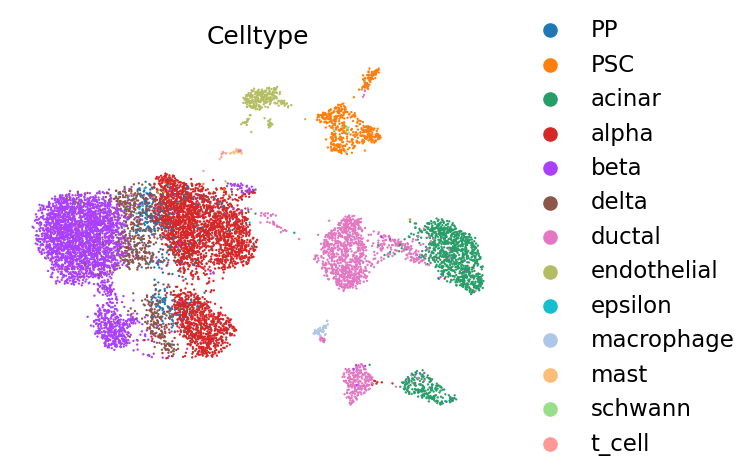

In [38]:
# Optional step to visualize the reference dataset using the embeddings
sc.pp.neighbors(ref_embed_adata, use_rep="X")
sc.tl.umap(ref_embed_adata)
sc.pl.umap(ref_embed_adata, color=cell_type_key, frameon=False, wspace=0.4)

In [47]:
# Preparing data
pancr_cells = pd.read_csv("../../hpap.pmacs-BetaCells/Data/FirstCountMatrix.csv", index_col=0)
pancr_cells = pancr_cells.transpose()
pancr_adata = sc.AnnData(pancr_cells)

In [48]:
# Filter out cells with zero total counts
sc.pp.filter_cells(pancr_adata, min_counts=1)

# Normalize the data to total counts per cell
sc.pp.normalize_total(pancr_adata, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(pancr_adata)

# Identify highly variable genes to keep
sc.pp.highly_variable_genes(pancr_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Subset the data to highly variable genes only
pancr_adata = pancr_adata[:, pancr_adata.var.highly_variable]

# Scale the data (mean 0, variance 1)
sc.pp.scale(pancr_adata, max_value=10)

#Subsetting and adding labels
beta_cell_labels_df = pd.read_csv("../../hpap.pmacs-BetaCells/Data/beta_cell_labels_prototype.csv")

beta_cell_labels = beta_cell_labels_df['x'].values

pancr_adata_beta = pancr_adata[pancr_adata.obs_names.isin(beta_cell_labels)].copy()

pancr_adata_beta.obs['Celltype'] = 'Beta'

/home/jon/anaconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/jon/anaconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/jon/anaconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the d

In [69]:
test_embed_adata = scg.tasks.embed_data(
    pancr_adata_beta,
    model_dir,
    gene_col=gene_col,
    obs_to_save=cell_type_key,  # optional arg, only for saving metainfo
    batch_size=64,
    return_new_adata=True,
)

scGPT - INFO - match 9784/10072 genes in vocabulary of size 60697.


/home/jon/anaconda3/envs/scGPT/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Embedding cells: 100%|████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]
/home/jon/anaconda3/envs/scGPT/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [86]:
ref_cell_embeddings = ref_embed_adata.X
test_emebd = test_embed_adata.X

k = 10  # number of neighbors

if faiss_imported:
    # Declaring index, using most of the default parameters from
    index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
    index.add(ref_cell_embeddings)

    # Query dataset, k - number of closest elements (returns 2 numpy arrays)
    distances, labels = index.search(test_emebd, k)

idx_list=[i for i in range(test_emebd.shape[0])]
preds = []
for k in idx_list:
    if faiss_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(test_emebd[k][np.newaxis, ...], ref_cell_embeddings, k)
    pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
    preds.append(pred.index[0])
gt = pancr_adata_beta.obs[cell_type_key].to_numpy()

sklearn.metrics.accuracy_score(gt, preds)

0.0

In [88]:
preds

['delta',
 'PP',
 'delta',
 'PP',
 'PP',
 'PP',
 'PP',
 'beta',
 'PP',
 'delta',
 'ductal',
 'delta',
 'delta',
 'PP',
 'delta',
 'PP',
 'delta',
 'PP',
 'PP',
 'PP',
 'delta',
 'beta',
 'PP',
 'PP',
 'PP',
 'delta',
 'delta',
 'delta',
 'delta',
 'delta',
 'delta',
 'delta',
 'PP',
 'PP',
 'PP',
 'delta',
 'PP',
 'delta',
 'PP',
 'delta',
 'delta',
 'PP',
 'PP',
 'delta',
 'delta',
 'PP',
 'delta',
 'PP',
 'delta',
 'delta',
 'PP',
 'PP',
 'delta',
 'PP',
 'delta',
 'delta',
 'PP',
 'PP',
 'delta',
 'delta',
 'PP',
 'PP',
 'PP',
 'delta',
 'PP',
 'PP',
 'delta',
 'delta',
 'PP',
 'delta',
 'PP',
 'PP',
 'delta',
 'delta',
 'PP',
 'delta',
 'PP',
 'PP',
 'delta',
 'delta',
 'PP',
 'delta',
 'PP',
 'delta',
 'delta',
 'delta',
 'delta',
 'PP',
 'delta',
 'delta',
 'delta',
 'PP',
 'delta',
 'delta',
 'PP',
 'beta',
 'delta',
 'delta',
 'delta',
 'PP',
 'PP',
 'beta',
 'PP',
 'PP',
 'delta',
 'delta',
 'delta',
 'PP',
 'delta',
 'delta',
 'PP',
 'delta',
 'PP',
 'PP',
 'delta',
 'delta',

In [84]:
len(gt)

4218

In [85]:
test_adata.obs[cell_type_key].to_numpy()

array(['beta', 'beta', 'beta', ..., 'PP', 'PP', 'PP'], dtype=object)

###  I need to do the tutorial with my dataset:

They are using a pancreas dataset!!!!

https://github.com/bowang-lab/scGPT/blob/main/tutorials/Tutorial_Reference_Mapping.ipynb


I should compare my small dataset to their reference dataset!

Specifically the section called:
Reference mapping using the CellXGene atlas



In [33]:
from build_atlas_index_faiss import load_index, vote

In [35]:
use_gpu = faiss.get_num_gpus() > 0
index, meta_labels = load_index(
    index_dir="../Data/faiss_index_folder/",
    use_config_file=False,
    use_gpu=use_gpu,
)
print(f"Loaded index with {index.ntotal} cells")

Loading index and meta from ../Data/faiss_index_folder/ ...
Index loaded, num_embeddings: 35096827
Set nprobe from 128 to 128 for 16384 clusters
Loaded index with 35096827 cells
